In [53]:
!pip install -r requirements.txt

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score

#Lettura del dataset

In [55]:
traindata = pd.read_csv("train.csv",index_col=[0])
testdata = pd.read_csv("test.csv",index_col=[0])

# Check dei valori nulli
La prima operazione da effettuare è il check dei valori nulli su tutti i campi dei due dataset, dato che un singolo valore nullo in un campo diverso da salary può far creare non pochi problemi.

In [56]:
print(traindata.isnull().sum())
print(testdata.isnull().sum())

status             0
gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
salary            45
dtype: int64
status             0
gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
salary            10
dtype: int64


#Descrizione del dataset

In [57]:
traindata.describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,137.000000,137.000000,137.000000,137.000000,137.000000,92.000000
mean,67.314380,66.197080,65.749927,73.059708,62.038321,285804.347826
std,10.701021,11.414077,7.505015,13.029185,5.820365,76669.583512
min,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,61.080000,61.000000,60.000000,62.000000,57.340000,240000.000000
50%,67.000000,64.890000,65.000000,71.200000,61.310000,265000.000000
75%,74.900000,73.000000,70.000000,84.000000,65.990000,300000.000000
max,87.000000,97.000000,85.000000,98.000000,76.180000,650000.000000


In [58]:
traindata.status.value_counts(normalize=True)

Placed        0.671533
Not Placed    0.328467
Name: status, dtype: float64

Possiamo vedere che nel training set, si hanno circa il 65% degli studenti che hanno ricevuto un'occupazione nel primo anno (1=Placed) ed il restante 35% non hanno ricevuto un'occupazione (0=not placed).

# Feature Selection
Heatmap:
Per la feature selection utilizzo una heatmap. Il comando df.corr() dei DataFrame, permette di ottenere una matrice di correlazione tra features NxN dove viene applicata la correlazione di ogni feature con l'altra.
I valori ottenuti sono stati visualizzati tramite una heatmap e vengono selezionate le feature con correlazione >0.4
Utilizzo soltanto le feature che hanno un valore di correlazione con la target feature superiore ad una treshold.

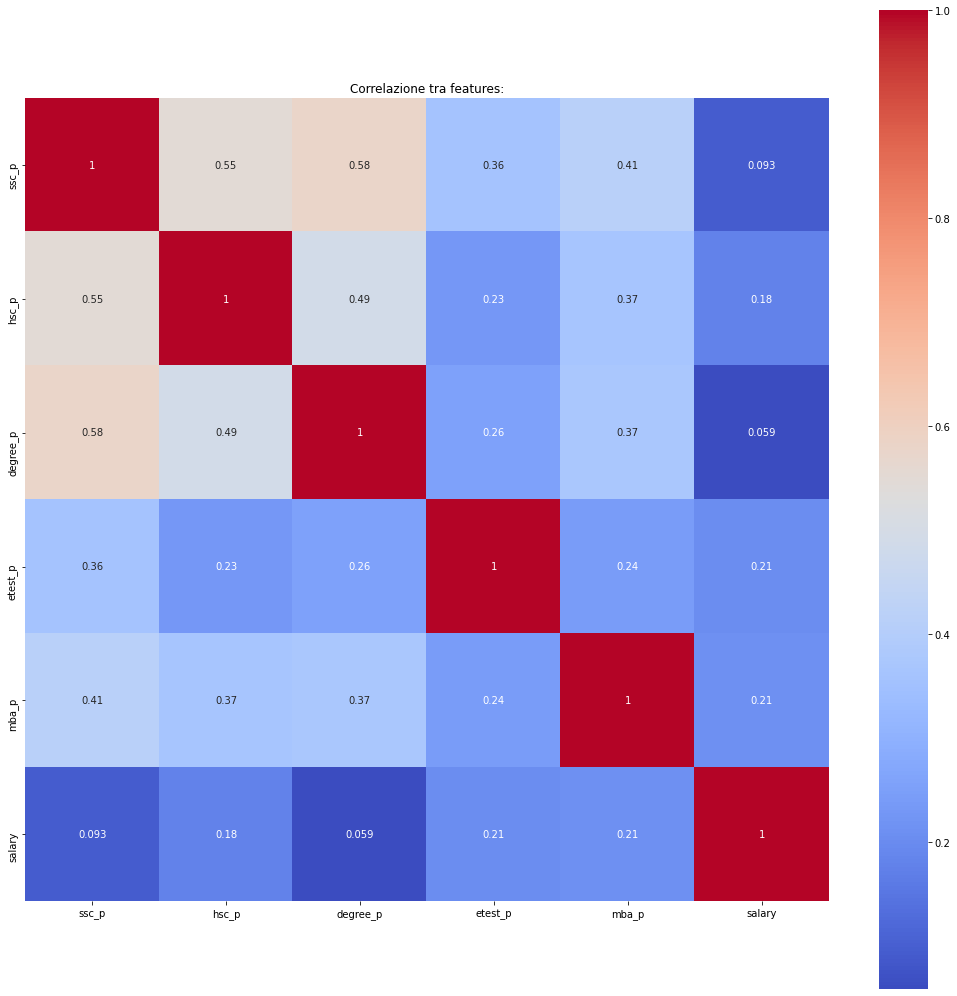

          ssc_p  hsc_p  degree_p  etest_p  mba_p  salary
ssc_p      True   True      True    False   True   False
hsc_p      True   True      True    False  False   False
degree_p   True   True      True    False  False   False
etest_p   False  False     False     True  False   False
mba_p      True  False     False    False   True   False
salary    False  False     False    False  False    True


In [59]:
correlation = traindata.corr()
plt.figure(figsize=(18,18))
sns.heatmap(correlation, vmax=1,  cmap='coolwarm', square=True,annot=True)
plt.title('Correlazione tra features:')
plt.show()
print(correlation>0.4)

In [60]:
#Ecco le feature che verranno utilizzate:
features_utilizzate = ['ssc_p','hsc_p','degree_p','mba_p']
#Seleziono le feature da utilizzare su test e train
X_train = traindata[features_utilizzate]
y_train = traindata.status
X_test = testdata[features_utilizzate]
y_test = testdata.status

In [61]:
# Label Encoding per le feature non numeriche
cat_cols = [cname for cname in X_train.columns if
                    X_train[cname].dtype == "object"]

# Seleziono le colonne numeriche
num_cols = [cname for cname in X_train.columns if
                X_train[cname].dtype in ['int64', 'float64']]

In [62]:
#pipeline per effettuare in sequenza le diverse operazioni sui dati
#i valori mancanti nel campo salary sono rimpiazzati con la media tramite l'imputer
#le variabili categoriche sono trasformate tramite OneHot-encoder creando delle nuove colonne che indicano,per ogni valore possibile presente nei dati, la presenza o l'assenza
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# preprocessamento dei dati in base al tipo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])

# applicando il criterio entropia, il root node effettua una partizione dei dati usando la feature che restituisce il valore d'informazione più alto
model = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=5, splitter='best')

In [63]:
#effettuo una riduzione della dimensionalità tramite la feature selection
# dichiaro la pipeline, cosi da consentire il trattamento dei dati, effettuando a cascata delle operazioni.
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('skb', SelectKBest(f_classif, k = 4)),
                              ('model', model)
                             ])
# effettuo il training sul modello
pipeline.fit(X_train, y_train)
# effettuo le predizioni
predicts = pipeline.predict(X_test)

In [64]:
# stampo la predizione effettuata
predicts

array(['Placed', 'Not Placed', 'Placed', 'Placed', 'Not Placed', 'Placed',
       'Not Placed', 'Not Placed', 'Placed', 'Not Placed', 'Not Placed',
       'Placed', 'Placed', 'Placed', 'Placed', 'Not Placed', 'Placed',
       'Not Placed', 'Placed', 'Placed', 'Placed', 'Placed', 'Placed',
       'Placed', 'Placed', 'Placed', 'Placed', 'Placed', 'Not Placed',
       'Placed', 'Not Placed', 'Placed', 'Not Placed', 'Placed',
       'Not Placed'], dtype=object)

In [65]:
#calcolo l'accuracy del modello
model=accuracy_score(predicts, y_test)*100
model


82.85714285714286